# Face on Face

In [ ]:
import cv2
import mediapipe as mp
import numpy as np

# Initialize Mediapipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)
# Function to detect landmarks
def detect_landmarks(image):
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks:
        return results.multi_face_landmarks[0]
    return None

# Function to get landmarks list
def get_landmarks_list(landmarks, image_shape):
    h, w = image_shape[:2]
    return [(int(landmark.x * w), int(landmark.y * h)) for landmark in landmarks.landmark]

# Load images
image1 = cv2.imread(r'C:\Users\myfir\My Drive\Skyline\Personal Expression\Smile.jpg')
image2 = cv2.imread(r'C:\Users\myfir\My Drive\Skyline\Personal Expression\Neutral.jpg')

# Detect landmarks
landmarks1 = detect_landmarks(image1)
landmarks2 = detect_landmarks(image2)

if not landmarks1 or not landmarks2:
    raise ValueError("Face landmarks not detected in one or both images")

# Get landmarks lists

landmarks_list1 = get_landmarks_list(landmarks1, image1.shape)
landmarks_list2 = get_landmarks_list(landmarks2, image2.shape)

# Create a transformation matrix to align the landmarks
pts1 = np.float32(landmarks_list1)
pts2 = np.float32(landmarks_list2)
transformation_matrix, _ = cv2.estimateAffinePartial2D(pts1, pts2)

# Transform landmarks from the first face
transformed_landmarks = cv2.transform(np.array(landmarks_list1).reshape(-1, 1, 2), transformation_matrix).reshape(-1, 2)

# Draw original landmarks on the second face in blue
for (x, y) in landmarks_list2:
    cv2.circle(image2, (int(x), int(y)), 1, (255, 0, 0), -1)

# Draw transformed landmarks from the first face on the second face in red
for (x, y) in transformed_landmarks:
    cv2.circle(image2, (int(x), int(y)), 1, (0, 0, 255), -1)

# Display the result
cv2.imshow('NEUTRAL | Blue is Smile, Red is Neutral', image2)
cv2.waitKey(0)
cv2.destroyAllWindows()




In [ ]:
import cv2
import mediapipe as mp
import numpy as np

# Initialize Mediapipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

# Function to detect landmarks
def detect_landmarks(image):
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks:
        return results.multi_face_landmarks[0]
    return None

# Function to get landmarks list
def get_landmarks_list(landmarks, image_shape):
    h, w = image_shape[:2]
    return [(int(landmark.x * w), int(landmark.y * h)) for landmark in landmarks.landmark]

# Load images
image1 = cv2.imread(r'C:\Users\myfir\My Drive\Skyline\Personal Expression\Close Up Smile.jpg')
image2 = cv2.imread(r'C:\Users\myfir\My Drive\Skyline\Personal Expression\Close up Neutral.jpg')

# Detect landmarks
landmarks1 = detect_landmarks(image1)
landmarks2 = detect_landmarks(image2)

if not landmarks1 or not landmarks2:
    raise ValueError("Face landmarks not detected in one or both images")

# Get landmarks lists

landmarks_list1 = get_landmarks_list(landmarks1, image1.shape)
landmarks_list2 = get_landmarks_list(landmarks2, image2.shape)

# Create a transformation matrix to align the landmarks
pts1 = np.float32(landmarks_list1)
pts2 = np.float32(landmarks_list2)
transformation_matrix, _ = cv2.estimateAffinePartial2D(pts1, pts2)

# Transform landmarks from the first face
transformed_landmarks = cv2.transform(np.array(landmarks_list1).reshape(-1, 1, 2), transformation_matrix).reshape(-1, 2)

# Draw original landmarks on the second face in blue
for (x, y) in landmarks_list2:
    cv2.circle(image2, (int(x), int(y)), 1, (255, 0, 0), -1)

# Draw transformed landmarks from the first face on the second face in red
for (x, y) in transformed_landmarks:
    cv2.circle(image2, (int(x), int(y)), 1, (0, 0, 255), -1)

# Display the result
cv2.imshow('NEUTRAL | Blue is Smile, Red is Neutral', image2)
cv2.waitKey(0)
cv2.destroyAllWindows()


# Landmark on Graphs

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import math

def alignNormalizedPoints(control : list, test: list):
    #index 152 is the bottom of the chin
    #index 10 is top of face
    #index 1 is tip of nose
    #index 168, 6 is middle of eyes
    #etc.
    #pointsOfAlignment = [10, 151, 9, 8, 168, 6, 197, 195, 5, 4, 1, 19, 94, 2, 152]
    #tearducts- 133, 362
    #pointsOfAlignment = [133, 362]

    #top of forehead, bottom of chin - 10, 152
    pointsOfAlignment = [10, 152]
    numPoints = len(pointsOfAlignment)
    delta = 0
    for poa in pointsOfAlignment:
        delta += control[poa] - test[poa]

    delta /= numPoints

    for i in range(len(test)):
        test[i] += delta

    #return control, yCon, test, yTest
    return test

def get():
    pass

def scalePoints(xCon: list, yCon: list, xTest: list, yTest: list, zCon: list, zTest: list):

    controlDistBetweenEyes = xCon[243] - xCon[362]
    testDistBetweenEyes = xTest[243] - xTest[362]

    scale = controlDistBetweenEyes / testDistBetweenEyes

    scaledXTest = list(map(lambda x: x * scale, xTest))
    scaledYTest = list(map(lambda y: y * scale, yTest))
    scaledZTest = list(map(lambda z: z * scale, zTest))
    
    return scaledXTest, scaledYTest, scaledZTest

def flipPoints(input: list):
    flippedPoints = []
    for index in range(len(input)):
        flippedPoints.append(1 - input[index])
    return flippedPoints

def rotate90CC(affine: np.array):
    rotateMatrix = np.array([[0, 1],
                             [-1, 0]])
    return np.dot(affine, rotateMatrix)

def affineTransform(X: list, Y: list):
    #https://stackoverflow.com/questions/74493141/align-x-and-y-coordinates-of-face-landmarks-in-r
    #133 is left eye tearduct, 362 is right
    #deltaX = X[133] - X[362]
    #deltaY = Y[133] - Y[362]

    #10 is top of forehead, 152 is bottom of chin
    deltaX = X[10] - X[152]
    deltaY = Y[10] - Y[152]
    theta = math.atan2(-deltaY, deltaX)

    rotationMatrix = np.array([[math.cos(theta), -math.sin(theta)],
                              [math.sin(theta), math.cos(theta)]])
    
    rotX = []
    rotY = []

    for x, y in zip(X, Y):
        rotateCoord = np.dot(rotationMatrix, np.array([x, y]))
        rotX.append(rotateCoord[0]) 
        rotY.append(rotateCoord[1])
    
    rotMatrix = np.column_stack((rotX, rotY))

    rotPoints = rotate90CC(rotMatrix)
    rotX = rotPoints[:, 0].tolist()
    rotY = rotPoints[:,1].tolist()

    return rotX, rotY

In [74]:


# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision


# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
control = mp.Image.create_from_file(r'C:\Users\myfir\My Drive\Skyline\Personal Expression\Neutral.jpg')
test = mp.Image.create_from_file(r'C:\Users\myfir\My Drive\Skyline\Personal Expression\Close Up Confused.jpg')

# STEP 4: Detect face landmarks from the input image.
control_result = detector.detect(control)
test_result = detector.detect(test)



c:\Users\myfir\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [75]:
#https://github.com/tensorflow/tfjs-models/blob/646992fd7ab8237c0dc908f2526301414b417c95/face-landmarks-detection/mesh_map.jpg

assert len(control_result.face_landmarks) == 1 , 'Not exactly one face detected in control image'
assert len(test_result.face_landmarks) == 1, 'Not exactly one face detected in test image'



xControl = [landmark.x for landmark in control_result.face_landmarks[0]]
yControl = [landmark.y for landmark in control_result.face_landmarks[0]]
zControl = [landmark.z for landmark in control_result.face_landmarks[0]]

xTest = [landmark.x for landmark in test_result.face_landmarks[0]]
yTest = [landmark.y for landmark in test_result.face_landmarks[0]]
zTest = [landmark.z for landmark in test_result.face_landmarks[0]]



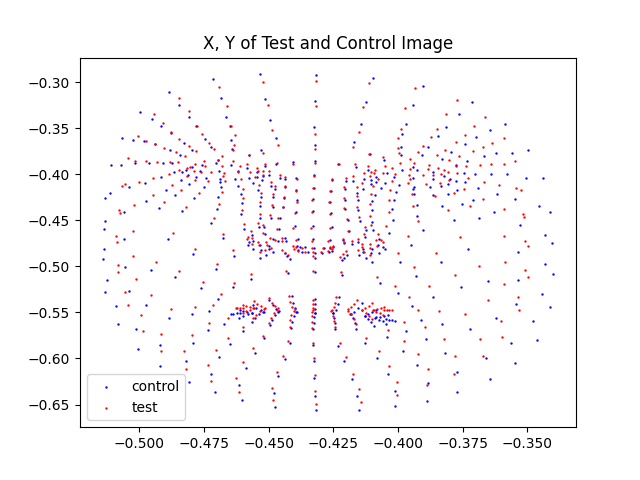

In [78]:
xControl, yControl = affineTransform(xControl, yControl)
xTest, yTest = affineTransform(xTest, yTest)

xTest, yTest, zTest = scalePoints(xControl, yControl, xTest, yTest, zControl, zTest)

xTest = alignNormalizedPoints(xControl, xTest)
yTest = alignNormalizedPoints(yControl, yTest)
zTest = alignNormalizedPoints(zControl, zTest)

#yControl = flipPoints(yControl)
#yTest = flipPoints(yTest)
#zControl = flipPoints(zControl)
#zTest = flipPoints(zTest)

fig = plt.figure()
plt.scatter(xControl, yControl, label = 'control', color = 'blue', s = .5)
plt.scatter(xTest, yTest, label = 'test', color = 'red', s = .5)
plt.title('X, Y of Test and Control Image')
plt.legend()
plt.show()

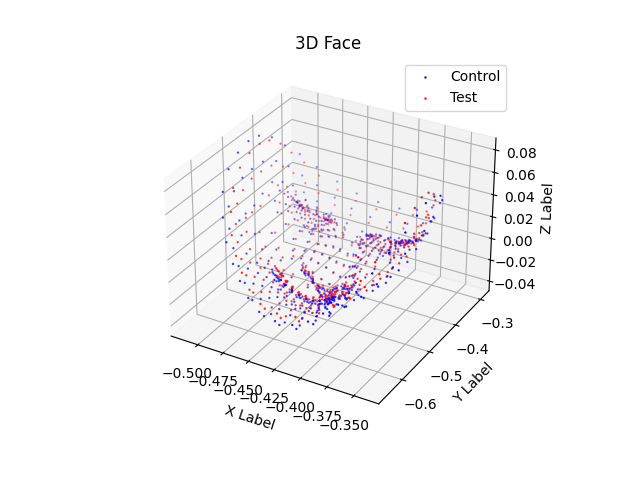

In [79]:
# Create a figure and a 3D Axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(xControl, yControl, zControl, c='b', marker='o', s= .5, label = 'Control')
ax.scatter(xTest, yTest, zTest, c='r', marker='o', s= .5, label = 'Test')
# Set labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Face')
ax.legend()

# Display the plot
%matplotlib ipympl
#%matplotlib notebook
plt.show()

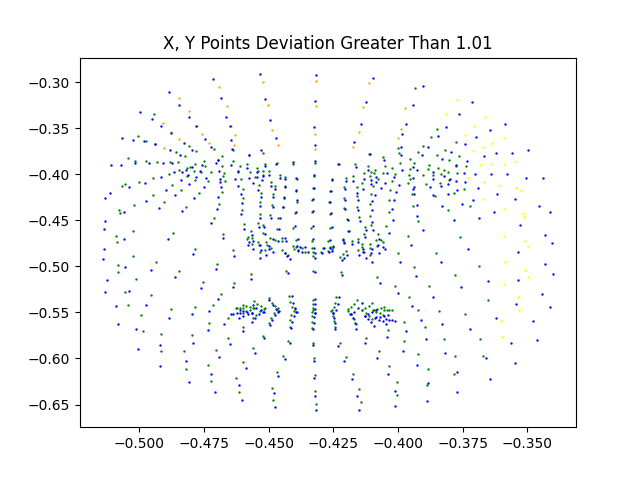

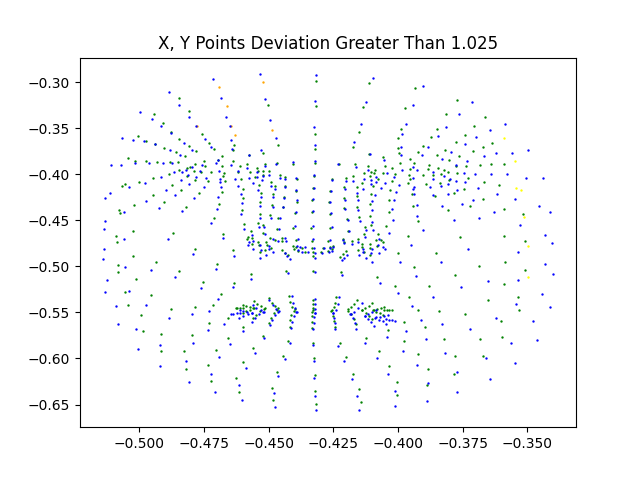

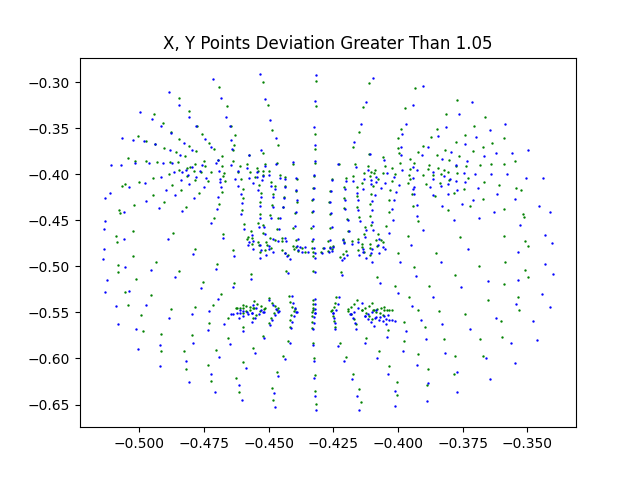

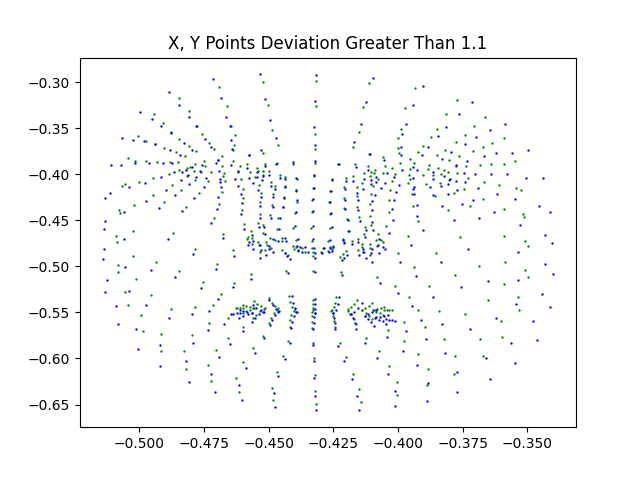

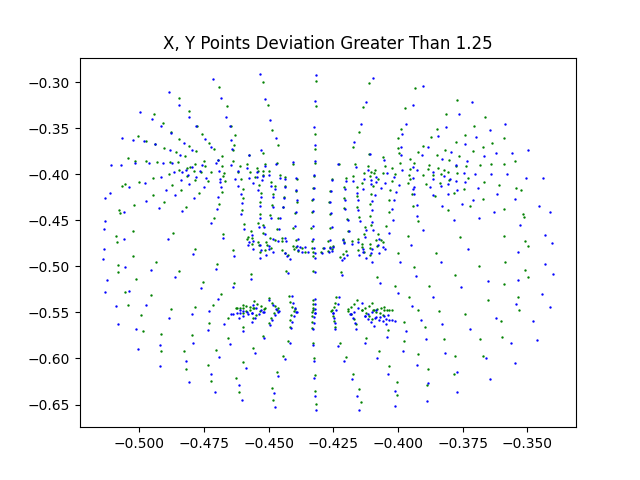

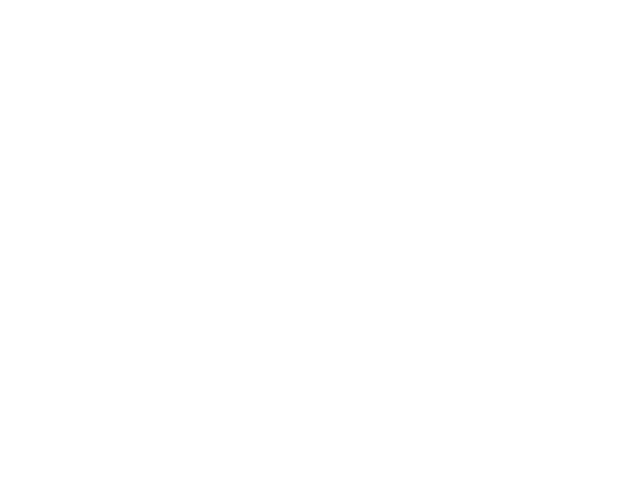

In [93]:
#plt.figure()

percents = [1.01, 1.025, 1.05, 1.1, 1.25]

xRatios = [abs(xt/xc) for xc, xt in zip(xControl, xTest)]
yRatios = [abs(yt/yc) for yc, yt in zip(yControl, yTest)]

for p in percents:
    plt.figure()
    handles = []
    labels = []
    for i, (xr, yr) in enumerate(zip(xRatios, yRatios)):
        if xr > p and yr > p:
            label = f'X, Y dev > {p}'
            color = 'red'
        elif xr > p:
            label = f'X dev > {p}'
            color = 'yellow'
        elif yr > p:
            label = f'Y dev > {p}'
            color = 'orange'
        else:
            label = 'No dev'
            color = 'green'
        handles.append(plt.scatter(xTest[i], yTest[i], color=color, s=.5))
        labels.append(label)
    control_handle = plt.scatter(xControl, yControl, color = 'blue', label = 'Control', s = .5)

    #plt.legend()
    plt.title(f'X, Y Points Deviation Greater Than {p}')
    plt.show()


In [91]:
set(labels)

{'No dev'}